In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from keras import layers
from keras.utils import get_file
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
gar_path = '/content/drive/MyDrive/Garbage classification/Garbage classification'
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

In [4]:
paths = []
labels = []
for dirname, _, filenames in os.walk(gar_path):
  for filename in filenames:
    if '.jpg' in filename:
      path = dirname + '/' + filename
      paths.append(path)
      
      if 'cardboard' in path:
        labels.append('0') # fcardboard = 0
      elif 'glass' in path:
        labels.append('1') # glass = 1
      elif 'metal' in path:
        labels.append('2') # metal = 2
      elif 'paper' in path:
        labels.append('3') # paper = 3
      elif 'plastic' in path:
        labels.append('4') # plastic = 4
      elif 'trash' in path:
        labels.append('5') # trash = 5


print(len(paths), len(labels))

2404 2404


In [33]:
data_gen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.2,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

val_gen = ImageDataGenerator(validation_split=0.2,
                             rescale = 1./255)


tr_flow_gen = data_gen.flow_from_directory(directory = gar_path,
                                         target_size = (180, 180), # 모델에 들어갈 인풋 이미지사이즈
                                         class_mode='categorical', 
                                         batch_size=64, # 한 번에 얼마만큼의 이미지 데이터를 가져올 것인지
                                         seed = 42,
                                         shuffle=True,
                                         subset='training')

val_flow_gen = val_gen.flow_from_directory(directory = gar_path,
                                         target_size = (180, 180), 
                                         class_mode='categorical', 
                                         batch_size=64, 
                                         seed = 42,
                                         shuffle=False,
                                         subset='validation')

Found 1925 images belonging to 6 classes.
Found 479 images belonging to 6 classes.


# CNN

In [24]:
cnn = tf.keras.models.Sequential()

cnn.add(layers.Conv2D(32, (3, 3),padding = 'same', activation='relu', input_shape=[128, 128, 3]))
cnn.add(layers.MaxPool2D(2))
cnn.add(layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same'))
cnn.add(layers.MaxPooling2D(2))
cnn.add(layers.Conv2D(64, 4, activation= 'relu', padding= 'same'))
cnn.add(layers.MaxPooling2D(2))
cnn.add(layers.Conv2D(128, 4, activation= 'relu', padding= 'same'))
cnn.add(layers.MaxPooling2D(2))
cnn.add(layers.Conv2D(256, 4, activation= 'relu', padding= 'same'))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(512, activation= 'relu'))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Dense(64, activation= 'relu'))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Dense(6, activation= 'softmax'))

cnn.summary()

cnn.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        32832     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)      

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
check_point = ModelCheckpoint('best_model.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

cnn_hist = cnn.fit(tr_flow_gen, epochs=100, validation_data = val_flow_gen)

Epoch 1/100
31/31 [==============================] - 17s 504ms/step - loss: 1.7986 - accuracy: 0.2145 - val_loss: 1.7294 - val_accuracy: 0.2359
Epoch 2/100
31/31 [==============================] - 15s 498ms/step - loss: 1.7379 - accuracy: 0.2208 - val_loss: 1.7271 - val_accuracy: 0.2359
Epoch 3/100
31/31 [==============================] - 15s 496ms/step - loss: 1.7253 - accuracy: 0.2244 - val_loss: 1.6396 - val_accuracy: 0.2839
Epoch 4/100
31/31 [==============================] - 16s 512ms/step - loss: 1.6130 - accuracy: 0.2940 - val_loss: 1.6819 - val_accuracy: 0.2714
Epoch 5/100
31/31 [==============================] - 15s 496ms/step - loss: 1.5799 - accuracy: 0.3158 - val_loss: 1.5880 - val_accuracy: 0.3173
Epoch 6/100
31/31 [==============================] - 15s 493ms/step - loss: 1.5781 - accuracy: 0.3247 - val_loss: 1.5958 - val_accuracy: 0.3445
Epoch 7/100
31/31 [==============================] - 15s 508ms/step - loss: 1.5547 - accuracy: 0.3200 - val_loss: 1.5795 - val_accuracy:

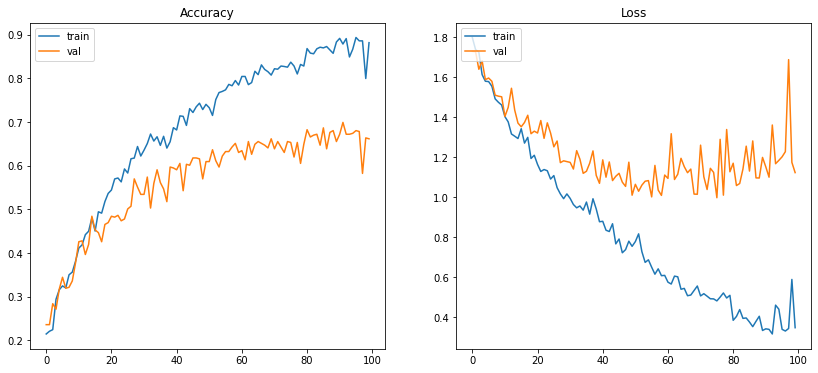

In [26]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [27]:
gar_test_path = '/content/drive/MyDrive/Garbage classification/Garbage classification TEST'
test_flow_gen = data_gen.flow_from_directory(directory = gar_test_path,
                                         target_size = (128, 128), # 모델에 들어갈 인풋 이미지사이즈
                                         class_mode='categorical', 
                                         batch_size=32, # 한 번에 얼마만큼의 이미지 데이터를 가져올 것인지
                                         seed = 42,
                                         shuffle=True)

Found 123 images belonging to 6 classes.


In [28]:
cnn.evaluate(test_flow_gen, verbose=1)

4/4 [==============================] - 26s 9s/step - loss: 1.1320 - accuracy: 0.7073


[1.1320185661315918, 0.707317054271698]

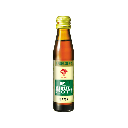

In [29]:
test_image2 = image.load_img('/content/drive/MyDrive/hwalmyeongsoo.jpg', target_size = (128, 128))
test_image2

In [30]:
test_image2 = image.img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis = 0)

result = cnn.predict(test_image2)
result = result[0]
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for i, acc in enumerate(result) :
    print(labels[i], "=", int(acc*100))
print("---")
print("예측한 결과 = " , labels[result.argmax()])

1/1 [==============================] - 0s 219ms/step
cardboard = 0
glass = 0
metal = 100
paper = 0
plastic = 0
trash = 0
---
예측한 결과 =  metal


# resnet


In [35]:
from tensorflow.keras.applications.resnet50 import ResNet50


resnet = ResNet50(include_top=False,
                  input_shape=(180,180,3),
                  classes=6,
                  weights='imagenet')
resnet.trainable = True
resnet_model = tf.keras.models.Sequential([resnet,
                                    Dense(128, activation='relu'),
                                    Flatten(),
                                    Dropout(0.5),
                                    Dense(512, activation='relu'),
                                    Dense(6, activation='softmax')
                                   ])
resnet_model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )
resnet_model.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
check_point = ModelCheckpoint('best_model.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

In [ ]:
resnet_hist= resnet_model.fit(tr_flow_gen, validation_data=val_flow_gen, epochs=100)

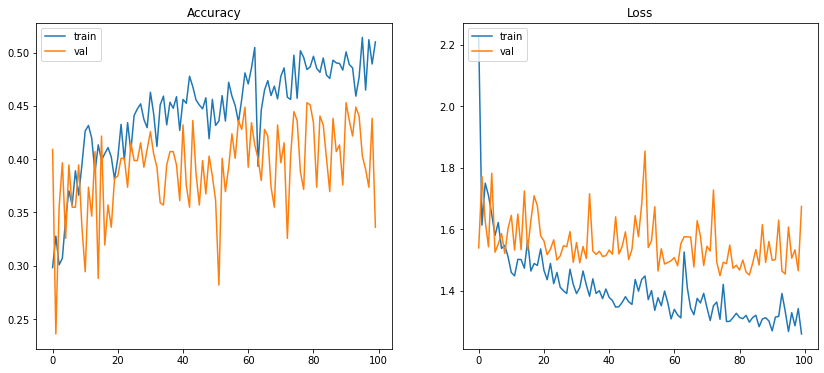

In [40]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

resnet 전혀 학습이 안됨..